# Assembling

This notebook is used to assemble a processable h5ad object for subsequent notebooks.

## Fill in input data, output and settings

In [19]:
#Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/processed_data' # specify the output directory of the processing should be the same in every notebook
test = 'Esophagus_146_0.01' # sample name, this should be the same for all the notebooks

In [20]:
################### DEFINING STRATEGY ###############################
from_h5ad = True #option 1
assembling_10_velocity = False #option 2
assembling_10_public = False #option 3
convert_seurat = False #option 4

###################### INPUT DATA ###################################

# For option 1: The path to an existing .h5ad file
h5ad_files = ['/mnt/workspace/jdetlef/data/anndata/esophagus_muscularis_146_0.01.h5ad']
#h5ad_files = ['/mnt/agnerds/PROJECTS/extern/ext442_scATAC_Glaser_11_22/preprocessing_output/data/all_annotated_peaks.h5ad']
merge_column='Sample_new' # (str) if multiple h5ad files merged this is an identifier from which file it originates
coordinate_cols=None # (list:str) columns where peak location data is stored (['chr', 'start', 'end'])
set_index=True # (boolean) should the adata.var index be formatted, that it matches chr:start-stop
index_from="name" # (str) should the index be generated from a certain column. Otherwise this is None (SnapATAC: name)

# Manually set existing QC Columns
n_features_by_counts = None
log1p_n_features_by_counts = None
total_counts = None
log1p_total_counts = None

mean_insertsize = None
nucleosomal_score_momentum = None
nucleosomal_score_cwt = None
genome_counts = None

n_fragments_in_promoters = None
pct_fragments_in_promoters = None
blacklist_overlaps = None
# total_number_of_fragments
TN = None # 'TN'
# uniquely_mapped_fragments
UM = None # 'UM'
# properly_paired_fragments
PP = None # 'PP'
# uniq_fragments
UQ = None # 'UQ'
# chrM_fragments
CM = None # 'CM'

#################### Calc QC Columns ###############################
# set available number of threads
n_threads = 8

# Step 1: QC Metrics
calc_qc_metrics = True # set True if the QC metrics should be calculated 

# Step 2 & 3
use_bam = True # False if fragments should be used
barcode_tag = 'CB' # set the tag where to find the barcode to use
# if Step 2, 3 or both is executed specify either a BAM file or a fragments file:
bam_file =  '/mnt/workspace/jdetlef/data/bamfiles/sorted_esophagus_muscularis_146_0.01.bam' # specify bamfile of the corresponding alignment
fragments_file = '/mnt/workspace/jdetlef/data/bamfiles/fragments_esophagus_muscularis_146_0.01.bed' # specify fragments file (if this is possible use the fragments file directly)

# Step 2: Calc metrics related to fragment length
calc_fragment_length_metrics = True # set True if the mean insertsize should be calculated

# Step 3: Promotor-enrichment
calc_promotor_enrichment = True # set True if the promotor-enrichment should be calculated
# specify promotors_gtf if another promoter than the fixed ones should be used
# if promotors is None please specify species
promoters_gtf =  '/mnt/workspace/jdetlef/data/homo_sapiens.104.promoters2000.gtf' # '/mnt/workspace/jdetlef/ext_ana/mus_musculus.104.promoters2000.gtf'
species = None

## Import modules

In [21]:
# sctoolbox modules 
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.fragment_length as fragments
import sctoolbox.atac as atac
import sctoolbox.calc_overlap_pct as overlap
import sctoolbox.analyser 
import sctoolbox.nucleosome_utils as nuc_utils
from sctoolbox.qc_filter import *
from sctoolbox.atac_utils import *
# import episcanpy
import episcanpy as epi

## Setup path handling object 

In [22]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Read in data

### Option 1: Read from .h5ad

In [23]:
qc_columns = {}
qc_columns["n_features_by_counts"] = n_features_by_counts
qc_columns["log1p_n_features_by_counts"] = log1p_n_features_by_counts
qc_columns["total_counts"] = total_counts
qc_columns["log1p_total_counts"] = log1p_total_counts

qc_columns["mean_insertsize"] = mean_insertsize
qc_columns['nucleosomal_score_momentum'] = nucleosomal_score_momentum
qc_columns['nucleosomal_score_cwt'] = nucleosomal_score_cwt
qc_columns['genome_counts'] = genome_counts

qc_columns['n_fragments_in_promoters'] = n_fragments_in_promoters
qc_columns['pct_fragments_in_promoters'] = pct_fragments_in_promoters
qc_columns["blacklist_overlaps"] = blacklist_overlaps

qc_columns["TN"] = TN
qc_columns["UM"] = UM
qc_columns["PP"] = PP
qc_columns["UQ"] = UQ
qc_columns["CM"] = CM

In [24]:
if from_h5ad:
    
    adata = assemble_from_h5ad(h5ad_files,
                       qc_columns,
                       merge_column=merge_column,
                       coordinate_cols=coordinate_cols,
                       set_index=set_index,
                       index_from=index_from)

Index(['peak_chr', 'peak_start', 'peak_end'], dtype='object')
add existing adata.obs columns to infoprocess:

setting adata.obs.index = adata.obs[barcode]


In [25]:
adata.obs

,TN,UM,PP,UQ,CM,file,sample,Sample_new
AAACTACCAGAAACCCGAGATA,33.0,18.0,18.0,15.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
AAACTACCAGAAACCTAAGTGG,52.0,36.0,35.0,32.0,1.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
AAACTACCAGAAACGGATCAGT,27.0,19.0,19.0,19.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
AAACTACCAGAAACGTCCCGTT,6223.0,5231.0,5213.0,3779.0,18.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
AAACTACCAGAAACTAGCCCTA,41.0,29.0,29.0,26.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
...,...,...,...,...,...,...,...,...
TTCCATCCTCTTTCGCGTGTAA,9.0,6.0,6.0,6.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
TTCCATCCTCTTTCTGCAGACT,10.0,6.0,6.0,6.0,1.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
TTCCATCCTCTTTCTGGCGCAG,17.0,5.0,5.0,5.0,1.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
TTCCATCCTCTTTGCCGGAAGG,8.0,7.0,7.0,7.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1


## Inspect adata

In [26]:
display(adata)

AnnData object with n_obs × n_vars = 73652 × 174262
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'Sample_new'
    var: 'peak_chr', 'peak_start', 'peak_end'
    uns: 'infoprocess', 'color_set'

In [27]:
display(adata.obs)

,TN,UM,PP,UQ,CM,file,sample,Sample_new
AAACTACCAGAAACCCGAGATA,33.0,18.0,18.0,15.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
AAACTACCAGAAACCTAAGTGG,52.0,36.0,35.0,32.0,1.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
AAACTACCAGAAACGGATCAGT,27.0,19.0,19.0,19.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
AAACTACCAGAAACGTCCCGTT,6223.0,5231.0,5213.0,3779.0,18.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
AAACTACCAGAAACTAGCCCTA,41.0,29.0,29.0,26.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
...,...,...,...,...,...,...,...,...
TTCCATCCTCTTTCGCGTGTAA,9.0,6.0,6.0,6.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
TTCCATCCTCTTTCTGCAGACT,10.0,6.0,6.0,6.0,1.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
TTCCATCCTCTTTCTGGCGCAG,17.0,5.0,5.0,5.0,1.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1
TTCCATCCTCTTTGCCGGAAGG,8.0,7.0,7.0,7.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1


## Calculate missing columns

### 1. calculate scanpy qc_metrics (n_features)

In [28]:
if qc_columns['n_features_by_counts'] is None or qc_columns['log1p_n_features_by_counts'] is None and calc_qc_metrics:
    adata = analyser.calculate_qc_metrics(adata, var_type='features')
    
    qc_columns['n_features_by_counts'] = 'n_features_by_counts'
    qc_columns['log1p_n_features_by_counts'] = 'log1p_n_features_by_counts'
    qc_columns['total_counts'] = 'total_counts'
    qc_columns['log1p_total_counts'] = 'log1p_total_counts'
    
    build_legend(adata, 'n_features_by_counts', 'n_features_by_counts')
    build_legend(adata, 'log1p_n_features_by_counts', 'log1p_n_features_by_counts')
    build_legend(adata, 'total_counts', 'total_counts')
    build_legend(adata, 'log1p_total_counts', 'log1p_total_counts')

adata.obs

,TN,UM,PP,UQ,CM,file,sample,Sample_new,n_features_by_counts,log1p_n_features_by_counts,total_counts,log1p_total_counts
AAACTACCAGAAACCCGAGATA,33.0,18.0,18.0,15.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,5,1.791759,5.0,1.791759
AAACTACCAGAAACCTAAGTGG,52.0,36.0,35.0,32.0,1.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,17,2.890372,17.0,2.890372
AAACTACCAGAAACGGATCAGT,27.0,19.0,19.0,19.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,10,2.397895,10.0,2.397895
AAACTACCAGAAACGTCCCGTT,6223.0,5231.0,5213.0,3779.0,18.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,1648,7.407924,1791.0,7.491087
AAACTACCAGAAACTAGCCCTA,41.0,29.0,29.0,26.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,13,2.639057,13.0,2.639057
...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCATCCTCTTTCGCGTGTAA,9.0,6.0,6.0,6.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,3,1.386294,3.0,1.386294
TTCCATCCTCTTTCTGCAGACT,10.0,6.0,6.0,6.0,1.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,3,1.386294,3.0,1.386294
TTCCATCCTCTTTCTGGCGCAG,17.0,5.0,5.0,5.0,1.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,0,0.000000,0.0,0.000000
TTCCATCCTCTTTGCCGGAAGG,8.0,7.0,7.0,7.0,0.0,/mnt/workspace/jdetlef/data/anndata/esophagus_...,MB,sample1,5,1.791759,5.0,1.791759


### check barcode tag

In [29]:
check_barcode_tag(adata, bam_file, barcode_tag)

Barcode tag: OK


### 2. calc mean insertsize and count if missing 

Counting fragment lengths from fragments file...
Done reading file - elapsed time: 0:04:24
Converting counts to dataframe...
Done getting insertsizes from fragments!
plotting density...


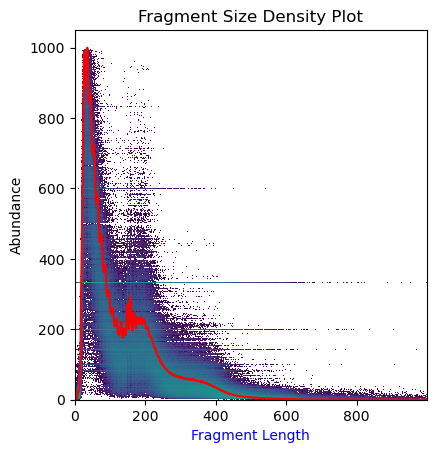

smoothing data...
calculating scores using the momentum method...
calculate momentum...
find peaks...


filter peaks...
plot single cell...
calc scores...
calculating scores using the continues wavelet transformation...
performing CWT on: 72987 cells
using wavelet type: gaus1
with scale: 16


In [ ]:
if calc_fragment_length_metrics:
    adata = nuc_utils.add_insertsize_metrics(adata,
                               bam=None,
                               fragments=fragments_file,
                               barcode_col=None,
                               barcode_tag="CB",
                               regions=None,
                               use_momentum=True,
                               use_cwt=True,
                               peaks_thr_mom=0.03,
                               peaks_thr_cwt=0.05)
    
    qc_columns['genome_counts'] = 'genome_counts'
    qc_columns['mean_insertsize'] = 'mean_insertsize'
    qc_columns['nucleosomal_score_momentum'] = 'nucleosomal_score_momentum'
    qc_columns['nucleosomal_score_cwt'] = 'nucleosomal_score_cwt'
    
    build_legend(adata, 'genome_counts', 'genome_counts')
    build_legend(adata, 'mean_insertsize', 'mean_insertsize')
    build_legend(adata, 'nucleosomal_score_momentum', 'nucleosomal_score_momentum')
    build_legend(adata, 'nucleosomal_score_cwt', 'nucleosomal_score_cwt')
    
    adata.obs

In [ ]:
adata.obs

### 3. promotor enrichment 

In [ ]:
if qc_columns['n_fragments_in_promoters'] is None and calc_promotor_enrichment:

    if use_bam:
        overlap.pct_fragments_in_promoters(adata, gtf_file=promoters_gtf, species=species, bam_file=bam_file, cb_col=None, nproc=1, cb_tag=barcode_tag)
    else:
        overlap.pct_fragments_in_promoters(adata, gtf_file=promoters_gtf, species=species, fragments_file=fragments_file, cb_col=None, nproc=1, cb_tag=barcode_tag)

    if calc_fragment_length_metrics:
        adata.obs.pop('n_total_fragments')
    else:
        adata.obs.rename(columns={'n_total_fragments': 'genome_counts'}, inplace=True)
        qc_columns['genome_counts'] = 'genome_counts'
        build_legend(adata, 'genome_counts', 'genome_counts')
        
    # update column dictionary
    qc_columns['n_fragments_in_promoters'] = 'n_fragments_in_promoters'
    qc_columns['pct_fragments_in_promoters'] = 'pct_fragments_in_promoters'
    # update infoprocess table
    build_legend(adata, 'genome_counts', 'genome_counts')
    build_legend(adata, 'n_fragments_in_promoters', 'n_fragments_in_promoters')
    build_legend(adata, 'pct_fragments_in_promoters', 'pct_fragments_in_promoters')


## Save adata to .h5ad

In [ ]:
adata_output = tree.assembled_anndata
adata_output

In [ ]:
#Saving the data
cr.build_infor(adata, "Test_number", test)
cr.build_infor(adata, "Anndata_path", output_dir)

adata_output = tree.assembled_anndata
adata.write(filename=adata_output)

In [ ]:
import os
import shutil
repo_path = os.getcwd()
notebook_name = '01_assembling.ipynb'
notebook_path = os.path.join(repo_path, notebook_name)
notebook_copy = os.path.join(tree.assemble_dir , notebook_name)
shutil.copyfile(notebook_path, notebook_copy)